
# 🔧 Feature Engineering Tutorial

---

## ✨ What is Feature Engineering?

Feature engineering = creating, transforming, and selecting variables to make models smarter.
In energy forecasting, it helps capture:

* 📅 daily/weekly cycles
* 🔁 lagged demand memory
* 🌦️ weather impacts
* ⚡ domain-specific effects

---

## Setup & Imports 🛠️

In [145]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [146]:
elering = pd.read_csv('data/electricity-production and consumption_2022.csv',  delimiter=';',decimal=',')
elering['timestamp'] = pd.to_datetime(elering['Kuupaev (Eesti aeg)'], dayfirst=True)
elering.set_index('timestamp', inplace=True)
elering.head()

,Ajatempel (UTC),Kuupaev (Eesti aeg),Tarbimine,Tootmine,Planeeritud tarbimine,Planeeritud tootmine
timestamp,,,,,,
2022-01-01 00:00:00,1640988000,01.01.2022 00:00,899.4,419.5,903.1,462.4
2022-01-01 01:00:00,1640991600,01.01.2022 01:00,892.1,431.9,935.8,469.1
2022-01-01 02:00:00,1640995200,01.01.2022 02:00,874.3,428.1,897.6,458.6
2022-01-01 03:00:00,1640998800,01.01.2022 03:00,860.1,435.7,878.5,471.9
2022-01-01 04:00:00,1641002400,01.01.2022 04:00,842.7,429.2,891.1,472.2


In [147]:
demand = elering[['Tarbimine']]
demand = demand.rename(columns = {'Tarbimine':'demand'})
demand.head()

,demand
timestamp,
2022-01-01 00:00:00,899.4
2022-01-01 01:00:00,892.1
2022-01-01 02:00:00,874.3
2022-01-01 03:00:00,860.1
2022-01-01 04:00:00,842.7


In [148]:
production = elering[['Tootmine']]
production = production.rename(columns = {'Tootmine':'production'})
production.head()

,production
timestamp,
2022-01-01 00:00:00,419.5
2022-01-01 01:00:00,431.9
2022-01-01 02:00:00,428.1
2022-01-01 03:00:00,435.7
2022-01-01 04:00:00,429.2


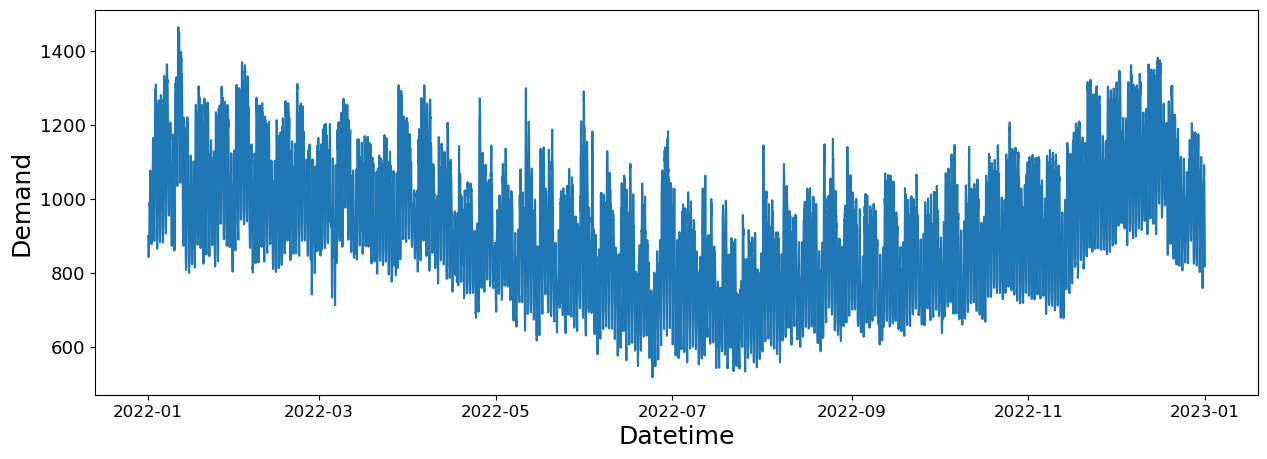

In [149]:
plt.figure(figsize=(15,5))
p=sns.lineplot(data= demand);
p.set_ylabel("Demand", fontsize = 18);
p.set_xlabel("Datetime", fontsize = 18);
plt.xticks(fontsize=12)
plt.yticks(fontsize=13)
plt.legend('', frameon=False);

---

# Feature Creation 🏗️

# Calendar features 📅

Extracting **hour, weekday, weekend** from the datetime index.

💡 **Why?** Demand follows strong cycles: weekdays differ from weekends; hours differ within the day.



---

### 📅 `datetime.date.today().weekday()`

* Returns an **integer 0–6**.
* **Monday = 0**, **Sunday = 6**.
* Follows **Python’s internal convention** (0-based, starting from Monday).

```python
import datetime
print(datetime.date(2024, 1, 1).weekday())   # 0 → Monday
print(datetime.date(2024, 1, 7).weekday())   # 6 → Sunday
```

---

## 📅 `datetime.date.today().isoweekday()`

* Returns an **integer 1–7**.
* **Monday = 1**, **Sunday = 7**.
* Follows the **ISO 8601 standard** (widely used in business).

```python
print(datetime.date(2024, 1, 1).isoweekday())   # 1 → Monday
print(datetime.date(2024, 1, 7).isoweekday())   # 7 → Sunday
```

---

## ✅ When to use which?

* Use `.weekday()` if you need **0-based indexing** (e.g., mapping weekdays into an array).
* Use `.isoweekday()` if you need **human-readable weekday numbers** (ISO calendar standard).

---


In [150]:
datetime.date.today().weekday()

1

In [151]:
datetime.date.today().isoweekday()

2

In [152]:
demand["hour"] = demand.index.hour
demand["weekday"] = demand.index.dayofweek
demand

,demand,hour,weekday
timestamp,,,
2022-01-01 00:00:00,899.4,0,5
2022-01-01 01:00:00,892.1,1,5
2022-01-01 02:00:00,874.3,2,5
2022-01-01 03:00:00,860.1,3,5
2022-01-01 04:00:00,842.7,4,5
...,...,...,...
2022-12-31 19:00:00,989.4,19,5
2022-12-31 20:00:00,932.5,20,5
2022-12-31 21:00:00,889.5,21,5


## Cyclical encoding of time ⏰
➡️ This avoids “23 and 0 are far apart” problem → models see **cyclic structure**.

### 🔄 Hour cyclical encoding

* `24` = period of the cycle (24 hours)
* Transforms `hour ∈ [0,23]` into a circle (sin, cos coordinates).


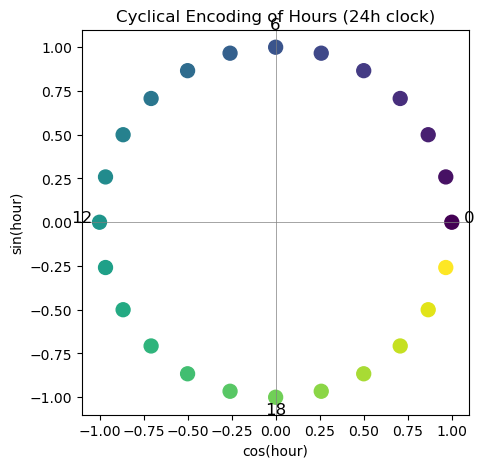

In [153]:
# Hours 0–23
hours = np.arange(24)
hour_sin = np.sin(2*np.pi*hours/24)
hour_cos = np.cos(2*np.pi*hours/24)

plt.figure(figsize=(5,5))
plt.scatter(hour_cos, hour_sin, c=hours, cmap="viridis", s=100)
for h in [0,6,12,18]:
    plt.text(hour_cos[h]*1.1, hour_sin[h]*1.1, str(h), fontsize=12, ha="center")
plt.title("Cyclical Encoding of Hours (24h clock)")
plt.xlabel("cos(hour)"); plt.ylabel("sin(hour)")
plt.axhline(0, color="gray", lw=0.5); plt.axvline(0, color="gray", lw=0.5)
plt.show()

In [154]:
demand["hour_sin"] = np.sin(2*np.pi*demand["hour"]/24)
demand["hour_cos"] = np.cos(2*np.pi*demand["hour"]/24)
demand

,demand,hour,weekday,hour_sin,hour_cos
timestamp,,,,,
2022-01-01 00:00:00,899.4,0,5,0.000000,1.000000
2022-01-01 01:00:00,892.1,1,5,0.258819,0.965926
2022-01-01 02:00:00,874.3,2,5,0.500000,0.866025
2022-01-01 03:00:00,860.1,3,5,0.707107,0.707107
2022-01-01 04:00:00,842.7,4,5,0.866025,0.500000
...,...,...,...,...,...
2022-12-31 19:00:00,989.4,19,5,-0.965926,0.258819
2022-12-31 20:00:00,932.5,20,5,-0.866025,0.500000
2022-12-31 21:00:00,889.5,21,5,-0.707107,0.707107


### 🔄 Weekday cyclical encoding

```python
demand["weekday_sin"] = np.sin(2*np.pi*demand["weekday"]/7)
demand["weekday_cos"] = np.cos(2*np.pi*demand["weekday"]/7)
```

* `7` = period of the cycle (7 days)
* Transforms `weekday ∈ [0,6]` into a circle (sin, cos coordinates).

---

✅ After this, your dataframe will have:

* `hour_sin`, `hour_cos` → capture **daily cycles**
* `weekday_sin`, `weekday_cos` → capture **weekly cycles**

---


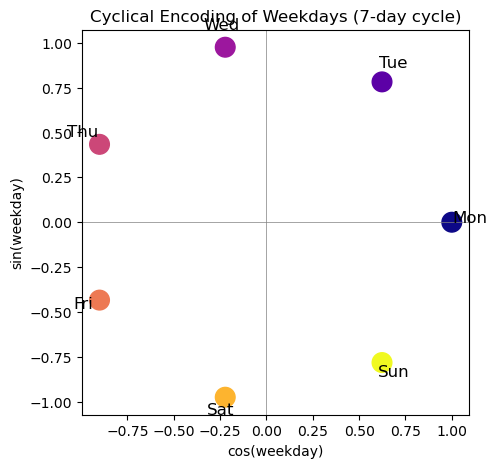

In [155]:
# Weekdays 0–6
weekdays = np.arange(7)
weekday_sin = np.sin(2*np.pi*weekdays/7)
weekday_cos = np.cos(2*np.pi*weekdays/7)

plt.figure(figsize=(5,5))
plt.scatter(weekday_cos, weekday_sin, c=weekdays, cmap="plasma", s=200)
for d, name in zip(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]):
    plt.text(weekday_cos[d]*1.1, weekday_sin[d]*1.1, name, fontsize=12, ha="center")
plt.title("Cyclical Encoding of Weekdays (7-day cycle)")
plt.xlabel("cos(weekday)"); plt.ylabel("sin(weekday)")
plt.axhline(0, color="gray", lw=0.5); plt.axvline(0, color="gray", lw=0.5)
plt.show()

In [156]:
demand["weekday_sin"] = np.sin(2*np.pi*demand["weekday"]/7)
demand["weekday_cos"] = np.cos(2*np.pi*demand["weekday"]/7)
demand

,demand,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos
timestamp,,,,,,,
2022-01-01 00:00:00,899.4,0,5,0.000000,1.000000,-0.974928,-0.222521
2022-01-01 01:00:00,892.1,1,5,0.258819,0.965926,-0.974928,-0.222521
2022-01-01 02:00:00,874.3,2,5,0.500000,0.866025,-0.974928,-0.222521
2022-01-01 03:00:00,860.1,3,5,0.707107,0.707107,-0.974928,-0.222521
2022-01-01 04:00:00,842.7,4,5,0.866025,0.500000,-0.974928,-0.222521
...,...,...,...,...,...,...,...
2022-12-31 19:00:00,989.4,19,5,-0.965926,0.258819,-0.974928,-0.222521
2022-12-31 20:00:00,932.5,20,5,-0.866025,0.500000,-0.974928,-0.222521
2022-12-31 21:00:00,889.5,21,5,-0.707107,0.707107,-0.974928,-0.222521



# 🔤 Feature encoding

Many datasets contain **non-numeric information** such as:

* **Day type** → `"workday"` vs `"weekend"`
* **Season** → `"winter"`, `"summer"`, `"autumn"`, `"spring"`
* **Plant type** → `"solar"`, `"wind"`, `"hydro"`, `"gas"`
* **Region** → `"North"`, `"South"`, `"East"`, `"West"`

Machine learning models usually require **numeric inputs**, so we need to **encode** categorical variables.

---

### Label Encoding 🔢

Each category becomes an integer:

```python
from sklearn.preprocessing import LabelEncoder

df = pd.DataFrame({"plant": ["Solar","Wind","Hydro","Wind","Solar"]})
le = LabelEncoder()
df["plant_encoded"] = le.fit_transform(df["plant"])
print(df)
```

⚠️ Problem: Implies **ordering** (e.g., `"Hydro"=0`, `"Solar"=1`, `"Wind"=2`), which may not make sense.
Better for **tree models** that can handle arbitrary numbers.

---

###  One-Hot Encoding (Dummy Variables) 🟩🟨

Each category becomes its own column (dummy variable):

```python
pd.get_dummies(df, columns=["plant"])
```

Example:

| plant | plant\_Hydro | plant\_Solar | plant\_Wind |
| ----- | ------------ | ------------ | ----------- |
| Solar | 0            | 1            | 0           |
| Wind  | 0            | 0            | 1           |
| Hydro | 1            | 0            | 0           |

⚠️ Always drop one column (`drop_first=True`) to avoid **multicollinearity** in linear regression.

---

### Ordinal Encoding 🏅

For categories with **natural order** (e.g., `"low" < "medium" < "high"`):

```python
mapping = {"low": 0, "medium": 1, "high": 2}
df["level"] = df["level"].map(mapping)
```

---

### ⚡ Examples

* **Daytype**: workday = 0, weekend = 1
* **Season**: one-hot encode `"winter"`, `"spring"`, `"summer"`, `"autumn"`
* **Plant type**: one-hot encode `"solar"`, `"wind"`, `"hydro"`
* **Tariff type**: `"peak"`, `"off-peak"`, `"night"` (ordinal if they follow hierarchy of prices)

---

✅ **Summary**:

* Use **label encoding** for simple models or tree-based algorithms.
* Use **one-hot encoding** for linear models or neural nets.
* Use **ordinal encoding** if categories have a **natural ranking**.


### Scales and measurments

https://studyonline.unsw.edu.au/blog/types-of-data


* from sklearn.preprocessing import OneHotEncoder
* from sklearn.preprocessing import OrdinalEncoder -- to integer

### 🔢 Example: Dummy Variables

In [157]:
demand['daytype'] = demand.index.to_series().apply(
    lambda d: "weekend" if d.weekday() >= 5 else "workday"
)
demand

,demand,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos,daytype
timestamp,,,,,,,,
2022-01-01 00:00:00,899.4,0,5,0.000000,1.000000,-0.974928,-0.222521,weekend
2022-01-01 01:00:00,892.1,1,5,0.258819,0.965926,-0.974928,-0.222521,weekend
2022-01-01 02:00:00,874.3,2,5,0.500000,0.866025,-0.974928,-0.222521,weekend
2022-01-01 03:00:00,860.1,3,5,0.707107,0.707107,-0.974928,-0.222521,weekend
2022-01-01 04:00:00,842.7,4,5,0.866025,0.500000,-0.974928,-0.222521,weekend
...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,989.4,19,5,-0.965926,0.258819,-0.974928,-0.222521,weekend
2022-12-31 20:00:00,932.5,20,5,-0.866025,0.500000,-0.974928,-0.222521,weekend
2022-12-31 21:00:00,889.5,21,5,-0.707107,0.707107,-0.974928,-0.222521,weekend


Many machine learning models (like linear regression) cannot directly work with **categorical variables** such as `"daytype" = workday/weekend`.
We convert them into **dummy variables** (also called **one-hot encoding**):

```
daytype     →   weekend   workday
workday         0         1
weekend         1         0
```

This way, models can use binary (0/1 or True/False) columns instead of text.

---

In [158]:
pd.get_dummies(demand['daytype'])

,weekend,workday
timestamp,,
2022-01-01 00:00:00,True,False
2022-01-01 01:00:00,True,False
2022-01-01 02:00:00,True,False
2022-01-01 03:00:00,True,False
2022-01-01 04:00:00,True,False
...,...,...
2022-12-31 19:00:00,True,False
2022-12-31 20:00:00,True,False
2022-12-31 21:00:00,True,False


#### ⚠️ Collinearity Problem

In example:

| timestamp           | weekend | workday |
| ------------------- | ------- | ------- |
| 2022-01-01 00:00:00 | True    | False   |
| 2022-01-02 00:00:00 | False   | True    |

* Notice that **one column is always the inverse of the other**.
* If `weekend = 1`, then `workday = 0`, and vice versa.
* This creates **perfect multicollinearity** — one column can be predicted perfectly from the other.

In regression models, this leads to the **dummy variable trap**: coefficients become unstable or not identifiable.

---

##### ✅ How to Handle

* **Drop one column**: keep only `weekend` (0 = workday, 1 = weekend).

  * The model interprets the missing category as the **baseline**.
* In `pandas.get_dummies()`, use:

```python
pd.get_dummies(df['daytype'], drop_first=True)
```

This avoids collinearity by keeping only `n-1` dummy columns.

---


In [159]:
demand["is_weekend"] = (demand["weekday"] >= 5).astype(int)
demand

,demand,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos,daytype,is_weekend
timestamp,,,,,,,,,
2022-01-01 00:00:00,899.4,0,5,0.000000,1.000000,-0.974928,-0.222521,weekend,1
2022-01-01 01:00:00,892.1,1,5,0.258819,0.965926,-0.974928,-0.222521,weekend,1
2022-01-01 02:00:00,874.3,2,5,0.500000,0.866025,-0.974928,-0.222521,weekend,1
2022-01-01 03:00:00,860.1,3,5,0.707107,0.707107,-0.974928,-0.222521,weekend,1
2022-01-01 04:00:00,842.7,4,5,0.866025,0.500000,-0.974928,-0.222521,weekend,1
...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,989.4,19,5,-0.965926,0.258819,-0.974928,-0.222521,weekend,1
2022-12-31 20:00:00,932.5,20,5,-0.866025,0.500000,-0.974928,-0.222521,weekend,1
2022-12-31 21:00:00,889.5,21,5,-0.707107,0.707107,-0.974928,-0.222521,weekend,1


# Lag Features 🔁

Creating **lag1, lag24, lag168**.

💡 **Why?** Demand today depends heavily on yesterday and the same hour last week.

➡️ Lags capture **autocorrelation** (yesterday’s demand helps predict today).

In [160]:
demand["lag1"] = demand["demand"].shift(1)
demand["lag24"] = demand["demand"].shift(24)
demand["lag168"] = demand["demand"].shift(168)
demand

,demand,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos,daytype,is_weekend,lag1,lag24,lag168
timestamp,,,,,,,,,,,,
2022-01-01 00:00:00,899.4,0,5,0.000000,1.000000,-0.974928,-0.222521,weekend,1,NaN,NaN,NaN
2022-01-01 01:00:00,892.1,1,5,0.258819,0.965926,-0.974928,-0.222521,weekend,1,899.4,NaN,NaN
2022-01-01 02:00:00,874.3,2,5,0.500000,0.866025,-0.974928,-0.222521,weekend,1,892.1,NaN,NaN
2022-01-01 03:00:00,860.1,3,5,0.707107,0.707107,-0.974928,-0.222521,weekend,1,874.3,NaN,NaN
2022-01-01 04:00:00,842.7,4,5,0.866025,0.500000,-0.974928,-0.222521,weekend,1,860.1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,989.4,19,5,-0.965926,0.258819,-0.974928,-0.222521,weekend,1,1042.8,1049.9,1009.5
2022-12-31 20:00:00,932.5,20,5,-0.866025,0.500000,-0.974928,-0.222521,weekend,1,989.4,1019.4,982.7
2022-12-31 21:00:00,889.5,21,5,-0.707107,0.707107,-0.974928,-0.222521,weekend,1,932.5,981.0,965.4


⚠️ Remember: when predicting the future, never use **future lags** (data leakage).

# Rolling Features 📊

Rolling mean & max smooth fluctuations and show short-term trends.

💡 Great for capturing **daily average** and **peak demand**.

➡️ Rolling averages smooth short-term fluctuations → useful for **trend detection**.


In [161]:
demand["roll_mean_24h"] = demand["demand"].rolling(24).mean()
demand["roll_max_24h"] = demand["demand"].rolling(24).max()

In [162]:
demand

,demand,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos,daytype,is_weekend,lag1,lag24,lag168,roll_mean_24h,roll_max_24h
timestamp,,,,,,,,,,,,,,
2022-01-01 00:00:00,899.4,0,5,0.000000,1.000000,-0.974928,-0.222521,weekend,1,NaN,NaN,NaN,NaN,NaN
2022-01-01 01:00:00,892.1,1,5,0.258819,0.965926,-0.974928,-0.222521,weekend,1,899.4,NaN,NaN,NaN,NaN
2022-01-01 02:00:00,874.3,2,5,0.500000,0.866025,-0.974928,-0.222521,weekend,1,892.1,NaN,NaN,NaN,NaN
2022-01-01 03:00:00,860.1,3,5,0.707107,0.707107,-0.974928,-0.222521,weekend,1,874.3,NaN,NaN,NaN,NaN
2022-01-01 04:00:00,842.7,4,5,0.866025,0.500000,-0.974928,-0.222521,weekend,1,860.1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,989.4,19,5,-0.965926,0.258819,-0.974928,-0.222521,weekend,1,1042.8,1049.9,1009.5,929.462500,1091.7
2022-12-31 20:00:00,932.5,20,5,-0.866025,0.500000,-0.974928,-0.222521,weekend,1,989.4,1019.4,982.7,925.841667,1091.7
2022-12-31 21:00:00,889.5,21,5,-0.707107,0.707107,-0.974928,-0.222521,weekend,1,932.5,981.0,965.4,922.029167,1091.7


# External Features

Weather  🌦️

💡 **Why?** Weather drives demand:

* Cold → heating 🔥
* Hot → cooling ❄️
* Cloudy → less PV ☁️

## 🌦️ Weather Features & Constructed Features in Energy Forecasting

Weather is one of the **main external drivers** of energy demand and renewable generation. Raw measurements can already help, but often we need to **aggregate** or **transform** them into features more suitable for modeling.

---

### 🔹 1. Temperature 🌡️

* **Main driver of demand**:

  * Cold → ↑ heating demand (electric heaters, district heating pumps).
  * Hot → ↑ cooling demand (air conditioning).
* **Options for “Estonia’s temperature”**:

  * 📍 Single station (Tallinn airport, Tartu, etc.).
  * 🗺️ Weighted average of multiple stations (e.g., by population or grid node demand).
  * 🛰️ Satellite reanalysis data (ERA5, Copernicus) aggregated over the country.

👉 Feature idea:

* **Heating Degree Days (HDD)**: `max(0, 18°C – T)`
* **Cooling Degree Days (CDD)**: `max(0, T – 18°C)`
  These capture **nonlinear effects** of temperature on demand.

---

### 🔹 2. Feels Like Temperature 🧍‍♂️💨

* Meteorological “feels like” (apparent temperature) combines:

  * air temperature,
  * humidity,
  * wind speed (wind chill),
  * solar radiation.
* Sometimes **explains demand better than raw temperature**, since it matches human comfort.

---

### 🔹 3. Wind Features 💨

Important for **wind power generation**:

* **Wind speed** (most critical). Turbine output \~ proportional to the **cube** of wind speed, up to rated power.
* **Wind direction**: matters for local effects (wake effects, terrain).
* **Turbulence / gusts**: can affect production quality and grid stability.

👉 Constructed features:

* `wind_power = wind_speed^3` (proxy for potential output).
* `wind_sector` (categorical: N, E, S, W).

---

### 🔹 4. Solar / Radiation ☀️

Key for **solar PV generation**:

* **Global horizontal irradiance (GHI)** or cloud cover %.
* **Clear-sky index** = (measured radiation / theoretical max).
* **Sun position features**: elevation angle, azimuth.

👉 Constructed features:

* `effective_radiation = (1 - cloud_cover) * max_radiation`
* `daylight_flag = 1 if sun_elevation > 0 else 0`

---

### 🔹 5. Humidity 💧

* High humidity affects **feels like** temperature.
* Can impact **heat pump efficiency** and thus electricity demand.

---

### 🔹 6. Precipitation 🌧️❄️

* Indirect effect on demand:

  * Rainy days → people stay home → higher residential demand.
  * Snowfall → can increase heating load or reduce PV output.

---

### 🔹 7. Composite Features 🧩

* **Interaction terms**:

  * `temp × humidity` (humid heat feels worse).
  * `wind_speed × cloud_cover` (windy + cloudy = low comfort).
* **Nonlinear transformations**: quadratic or piecewise temp-demand relationship.
* **Regional aggregation**:

  * Weighted averages across weather stations (by population or demand share).
  * Grid-level averages (for transmission zones).

---

### ✅ Summary

Weather features can be:

* **Raw**: temperature, wind speed, radiation, humidity, precipitation.
* **Constructed**:

  * HDD, CDD (comfort thresholds).
  * Feels like temperature.
  * Nonlinear transforms (wind³, log radiation).
  * Aggregated across regions (weighted averages).

* **Domain-specific**:

  * Wind turbine output curves.
  * Solar irradiance corrected for cloud cover.

These features help models capture the **true drivers of demand and renewable generation**, beyond raw weather variables.



In [163]:
weather = pd.read_csv('data/weather_2022.csv',  delimiter=';', decimal='.', index_col = False)
weather['timestamp'] = pd.to_datetime(weather['Local time in Tallinn (airport)'], dayfirst=True)
weather

,Local time in Tallinn (airport),T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Ch,VV,Td,RRR,tR,E,Tg,E',sss,timestamp
0,31.12.2022 23:00,5.8,744.1,747.2,-0.7,93.0,Wind blowing from the south-southwest,3.0,NaN,NaN,...,NaN,35.0,4.8,0.1,3.0,NaN,NaN,NaN,NaN,2022-12-31 23:00:00
1,31.12.2022 22:00,5.9,744.3,747.3,-0.5,93.0,Wind blowing from the south-west,4.0,9.0,10.0,...,NaN,35.0,4.8,0.2,3.0,NaN,NaN,NaN,NaN,2022-12-31 22:00:00
2,31.12.2022 21:00,5.8,744.4,747.4,-0.3,93.0,Wind blowing from the south-southwest,4.0,8.0,NaN,...,NaN,35.0,4.8,0.2,3.0,NaN,NaN,NaN,NaN,2022-12-31 21:00:00
3,31.12.2022 20:00,5.7,744.8,747.8,-0.5,94.0,Wind blowing from the south-west,4.0,9.0,NaN,...,NaN,35.0,4.8,0.5,12.0,NaN,NaN,NaN,NaN,2022-12-31 20:00:00
4,31.12.2022 19:00,5.4,744.8,747.9,-0.8,96.0,Wind blowing from the south-west,4.0,8.0,NaN,...,NaN,20.0,4.8,0.3,3.0,NaN,NaN,NaN,NaN,2022-12-31 19:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,01.01.2022 04:00,-0.1,748.8,751.9,0.5,100.0,Wind blowing from the north-east,2.0,NaN,NaN,...,NaN,0.9,-0.1,1.0,3.0,NaN,NaN,NaN,NaN,2022-01-01 04:00:00
8728,01.01.2022 03:00,-0.1,748.5,751.6,0.4,99.0,Wind blowing from the north-east,1.0,NaN,NaN,...,NaN,0.4,-0.2,0.8,3.0,NaN,NaN,NaN,NaN,2022-01-01 03:00:00
8729,01.01.2022 02:00,0.0,748.2,751.3,0.2,99.0,Wind blowing from the east,1.0,NaN,NaN,...,NaN,0.4,-0.1,0.5,3.0,NaN,NaN,NaN,NaN,2022-01-01 02:00:00
8730,01.01.2022 01:00,-0.6,748.3,751.4,1.2,99.0,Wind blowing from the north-northwest,1.0,NaN,NaN,...,NaN,0.3,-0.7,0.2,3.0,NaN,NaN,NaN,NaN,2022-01-01 01:00:00


In [164]:
temperature = weather[['timestamp', 'T']]
temperature.set_index('timestamp', inplace=True)
demand = demand.join(temperature)

demand

,demand,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos,daytype,is_weekend,lag1,lag24,lag168,roll_mean_24h,roll_max_24h,T
timestamp,,,,,,,,,,,,,,,
2022-01-01 00:00:00,899.4,0,5,0.000000,1.000000,-0.974928,-0.222521,weekend,1,NaN,NaN,NaN,NaN,NaN,-1.0
2022-01-01 01:00:00,892.1,1,5,0.258819,0.965926,-0.974928,-0.222521,weekend,1,899.4,NaN,NaN,NaN,NaN,-0.6
2022-01-01 02:00:00,874.3,2,5,0.500000,0.866025,-0.974928,-0.222521,weekend,1,892.1,NaN,NaN,NaN,NaN,0.0
2022-01-01 03:00:00,860.1,3,5,0.707107,0.707107,-0.974928,-0.222521,weekend,1,874.3,NaN,NaN,NaN,NaN,-0.1
2022-01-01 04:00:00,842.7,4,5,0.866025,0.500000,-0.974928,-0.222521,weekend,1,860.1,NaN,NaN,NaN,NaN,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,989.4,19,5,-0.965926,0.258819,-0.974928,-0.222521,weekend,1,1042.8,1049.9,1009.5,929.462500,1091.7,5.4
2022-12-31 20:00:00,932.5,20,5,-0.866025,0.500000,-0.974928,-0.222521,weekend,1,989.4,1019.4,982.7,925.841667,1091.7,5.7
2022-12-31 21:00:00,889.5,21,5,-0.707107,0.707107,-0.974928,-0.222521,weekend,1,932.5,981.0,965.4,922.029167,1091.7,5.8


In [165]:
wind = weather[['timestamp', 'DD']]
wind.set_index('timestamp', inplace=True)
wind

,DD
timestamp,
2022-12-31 23:00:00,Wind blowing from the south-southwest
2022-12-31 22:00:00,Wind blowing from the south-west
2022-12-31 21:00:00,Wind blowing from the south-southwest
2022-12-31 20:00:00,Wind blowing from the south-west
2022-12-31 19:00:00,Wind blowing from the south-west
...,...
2022-01-01 04:00:00,Wind blowing from the north-east
2022-01-01 03:00:00,Wind blowing from the north-east
2022-01-01 02:00:00,Wind blowing from the east


In [166]:
print("Wind blowing from the south-southwest".replace('Wind blowing from the ', ''))

south-southwest


In [167]:
wind['DD'] = wind['DD'].str.replace('Wind blowing from the ', '')
wind

,DD
timestamp,
2022-12-31 23:00:00,south-southwest
2022-12-31 22:00:00,south-west
2022-12-31 21:00:00,south-southwest
2022-12-31 20:00:00,south-west
2022-12-31 19:00:00,south-west
...,...
2022-01-01 04:00:00,north-east
2022-01-01 03:00:00,north-east
2022-01-01 02:00:00,east


In [168]:
pd.get_dummies(wind['DD'])

,"Calm, no wind",east,east-northeast,east-southeast,north,north-east,north-northeast,north-northwest,north-west,south,south-east,south-southeast,south-southwest,south-west,west,west-northwest,west-southwest
timestamp,,,,,,,,,,,,,,,,,
2022-12-31 23:00:00,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
2022-12-31 22:00:00,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2022-12-31 21:00:00,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
2022-12-31 20:00:00,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
2022-12-31 19:00:00,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01 04:00:00,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2022-01-01 03:00:00,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2022-01-01 02:00:00,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# 🔄 Feature Transformation

Not all features are well-behaved. Many real-world energy variables (e.g., electricity prices, peak demand, wind output) are **skewed** or **nonlinear**. Feature transformations help to:

* 📉 Reduce skewness
* 📊 Stabilize variance
* 📈 Reveal hidden relationships
* 🤖 Improve model assumptions (e.g., normality)

---

## 🔹 Log Transformation (Logarithm)

* Applies: $x' = \log(1 + x)$ (often log1p to handle zeros).
* Reduces the impact of **extreme outliers**.
* Useful for **electricity prices** (long tail of high spikes).

✅ Turns a highly skewed distribution into something closer to normal.


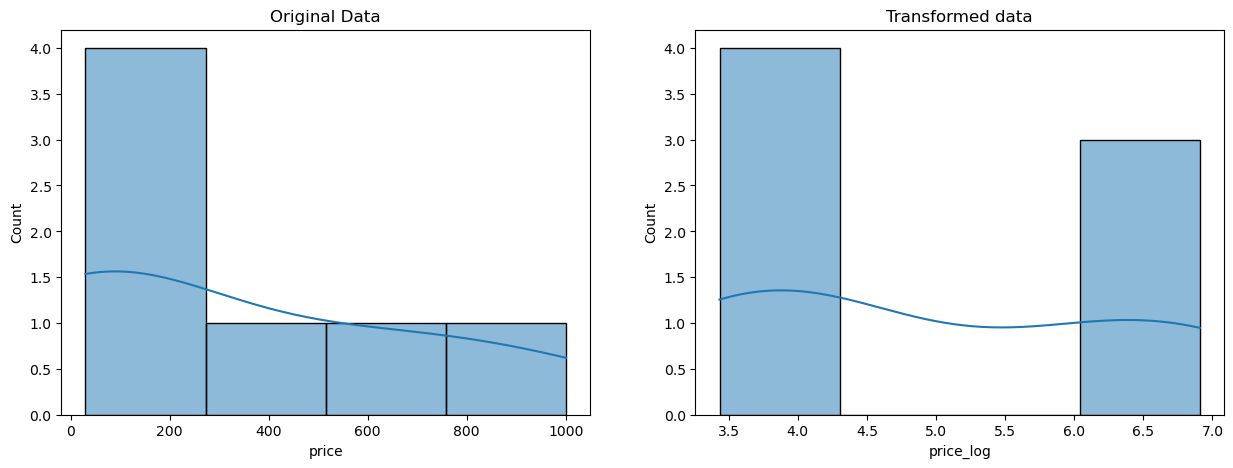

In [169]:
df = pd.DataFrame({"price":[30,40,50,60,500,700,1000]})
df["price_log"] = np.log1p(df["price"])


# plot both together to compare
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df['price'], ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(df['price_log'], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Transformed data")
plt.show()



## 🔹 Power Transformation

* Generalization of log.
* Example: **Square root transform** $x' = \sqrt{x}$
* Often used when variance increases with magnitude (heteroskedasticity).


💡 In energy demand, the square root can stabilize fluctuations at high loads.

---


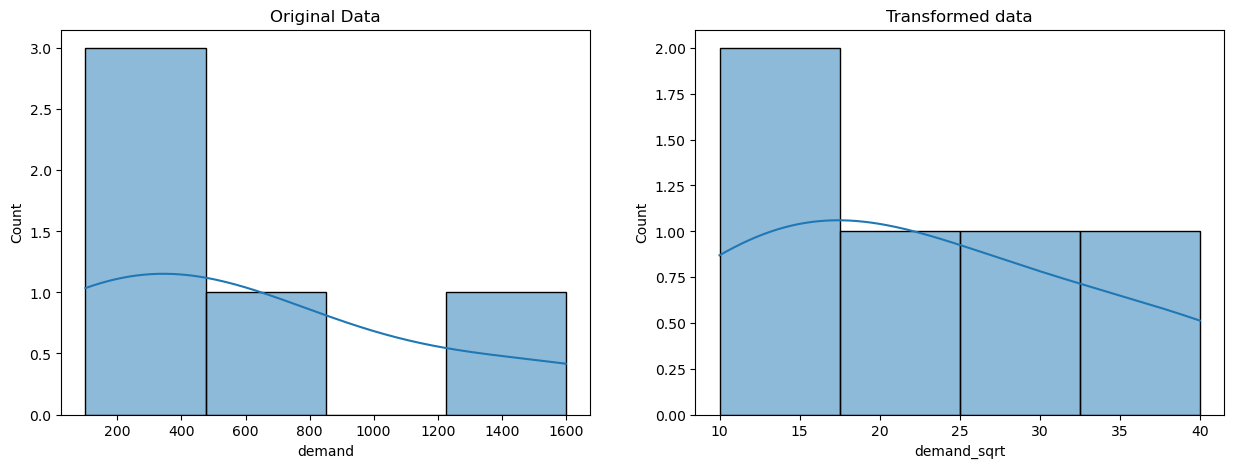

In [170]:
df = pd.DataFrame({"demand":[100,200,400,800,1600]})
df["demand_sqrt"] = np.sqrt(df["demand"])

# plot both together to compare
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(df['demand'], ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(df['demand_sqrt'], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Transformed data")
plt.show()

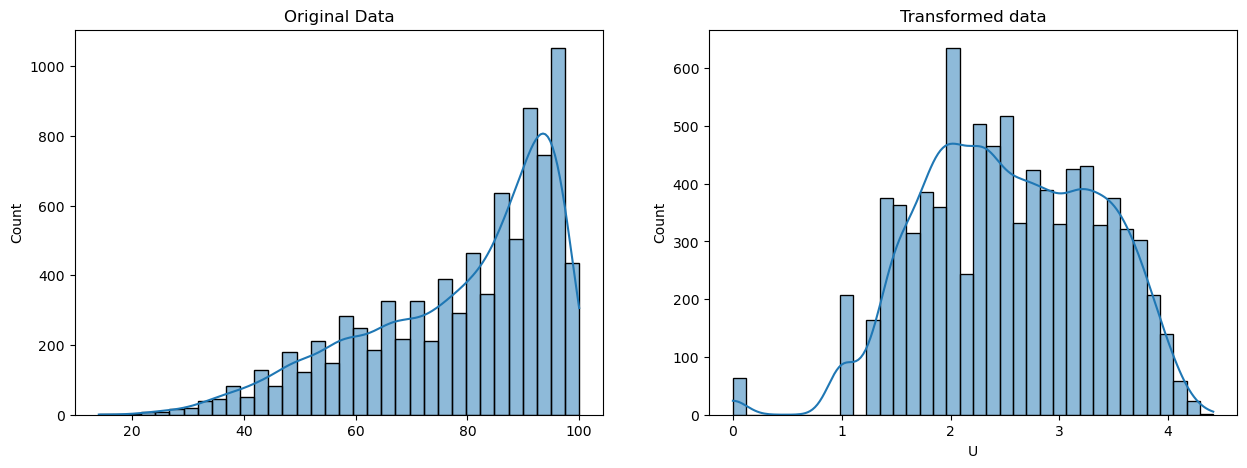

In [171]:
original_data = weather [['U']]

#transformed_data = np.power(original_data, 1/2)
transformed_data = np.power(max(original_data['U'])-original_data['U'], 1/3)

# plot both together to compare
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(transformed_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Transformed data")
plt.show()

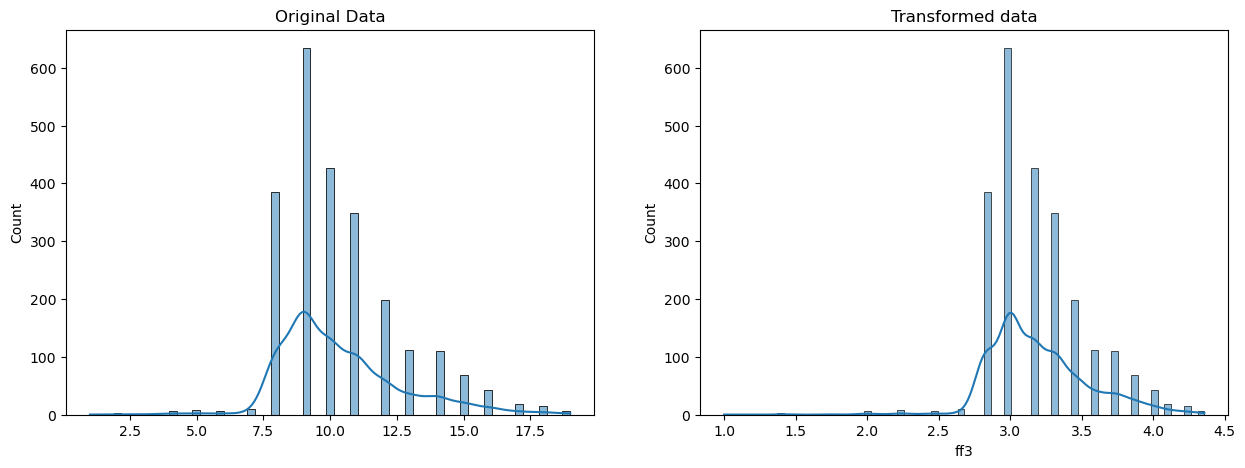

In [172]:
original_data = weather [['ff3']]

transformed_data = np.power(original_data['ff3'], 1/2)

# plot both together to compare
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(transformed_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Transformed data")
plt.show()

## ⚖️ Scaling and Normalization

When working with machine learning models, we often need to **adjust feature values** so that they are on a comparable scale.
This step is especially important for algorithms based on **distance (kNN, clustering)** or **gradient descent (linear regression, neural nets, SVMs)**.


It’s easy to confuse **scaling** and **normalization** because the terms are sometimes used interchangeably. Both involve transforming numerical variables so the data has more useful properties.

The key distinction is:

* **Scaling** → changes the **range** of the data.
* **Normalization** → changes the **distribution shape** of the data.

Let’s break them down:



---

### 🔹 Scaling

Scaling means transforming data so it fits within a specific range (for example, 0–1 or 0–100).

📌 **When to use it?**

* With algorithms based on **distance or similarity** (e.g., Support Vector Machines, k-Nearest Neighbors, clustering).
* These models treat a change of “1” in any feature as equally important, so features measured in different units must be made comparable.

📊 **Example:**
Imagine you have product prices in both **Yen** and **US Dollars**.

* 1 USD ≈ 100 Yen.
* Without scaling, a difference of **1 Yen** would be treated the same as **1 USD**, which is misleading.

Currency can be converted, but what if you compare **height (in cm)** and **weight (in kg)**? There’s no natural conversion. Scaling solves this by bringing all variables onto the same footing.


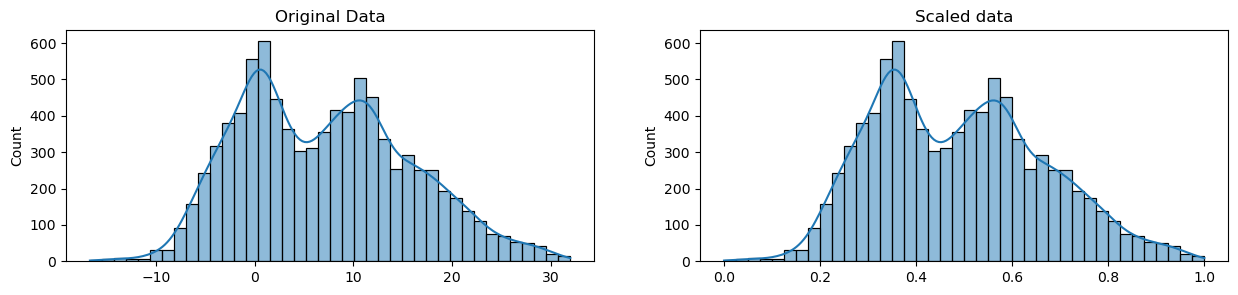

In [173]:
from sklearn.preprocessing import minmax_scale
original_data = temperature

# mix-max scale the data between 0 and 1
scaled_data = minmax_scale(temperature)

# plot both together to compare
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(scaled_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Scaled data")
plt.show()


#### 🌦️ Scaling Weather Features

When preprocessing weather data (like **temperature**), the choice of scaling range is important.

* **Min–Max scaling to \[0,1]** works fine for features that are strictly positive (e.g., solar irradiance, wind speed).
* But for **temperature**, values can be **negative in winter** and **positive in summer**.

---

##### ⚠️ Why \[0,1] is a problem

If we scale to \[0,1]:

* Negative winter temperatures get squeezed into values close to **0**.
* Positive summer temperatures stretch toward **1**.
* This makes the feature **asymmetric**, and the model may interpret “cold” as just “near zero” instead of truly “low”.

---

##### ✅ Better option: scale to \[-1,1]

By scaling to **\[-1,1]**:

* Negative values map naturally to the **negative side**.
* Positive values map to the **positive side**.
* The scaling is **symmetric around zero**, which often matches physical meaning better (below vs above freezing).

---

##### ⚡ Example

* For **Estonian winter & summer temperatures**, scaling to \[-1,1] lets models recognize that **-15°C** is as extreme (cold) as **+25°C** is extreme (warm).
* This symmetry is useful when modeling **heating vs cooling demand**.

---

✅ **Summary:**

* Use **\[0,1] scaling** for variables that are strictly non-negative (wind speed, irradiance).
* Use **\[-1,1] scaling** for variables that cross zero (temperature), to preserve meaning of “below vs above normal”.


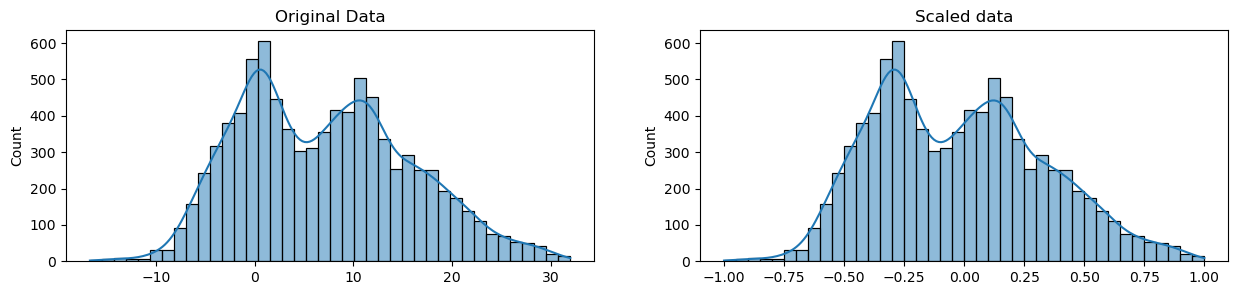

In [174]:
original_data = temperature

# mix-max scale the data between a and b
scaled_data = minmax_scale(temperature,  feature_range=(-1,1))

# plot both together to compare
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(scaled_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Scaled data")
plt.show()


### 🔹 Normalization

Normalization means transforming your data so that it follows a **normal distribution** (the familiar bell curve).

* In a normal distribution, most values are close to the mean, fewer are far away, and the distribution is symmetric.
* Mean ≈ Median ≈ Mode.

📌 **When to use it?**

* With algorithms that **assume normality** of features, such as:

  * Linear Discriminant Analysis (LDA)
  * Gaussian Naïve Bayes
  * Any method with “Gaussian” in its name

📊 **Example:**
Energy demand or market prices often have **skewed distributions** (long tail of extreme values).

* Normalization methods like **Box-Cox** or **Yeo-Johnson** can transform the data into something closer to a bell curve.
* This makes it easier for models that assume normality to work correctly.

---

#### 🔧 Common Normalization Techniques

* **Box-Cox transformation** → works for strictly positive data.
* **Yeo-Johnson transformation** → handles zeros and negative values.



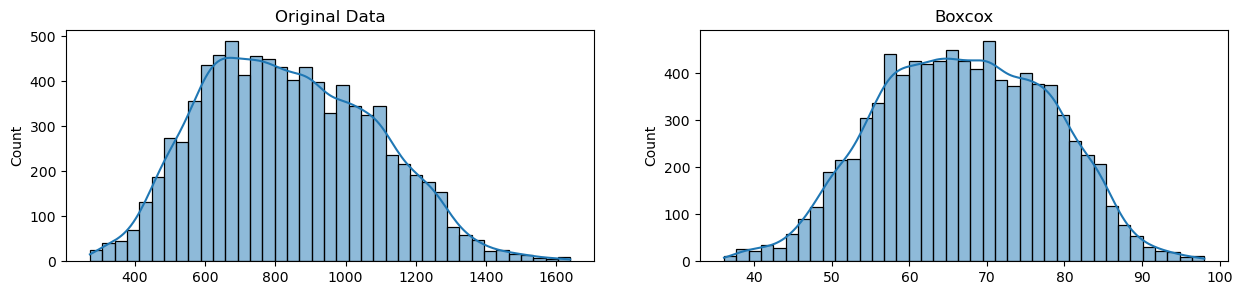

In [175]:
from scipy import stats

# normalize the exponential data with boxcox
normalized_data = stats.boxcox(production['production'])
original_data = production
# plot both together to compare
fig, ax=plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(normalized_data[0], ax=ax[1], kde=True, legend=False)
ax[1].set_title("Boxcox")
plt.show()


#### 🔹 Box-Cox and Yeo-Johnson

* **Box-Cox** → works only for positive values.
* **Yeo-Johnson** → works for positive and negative.



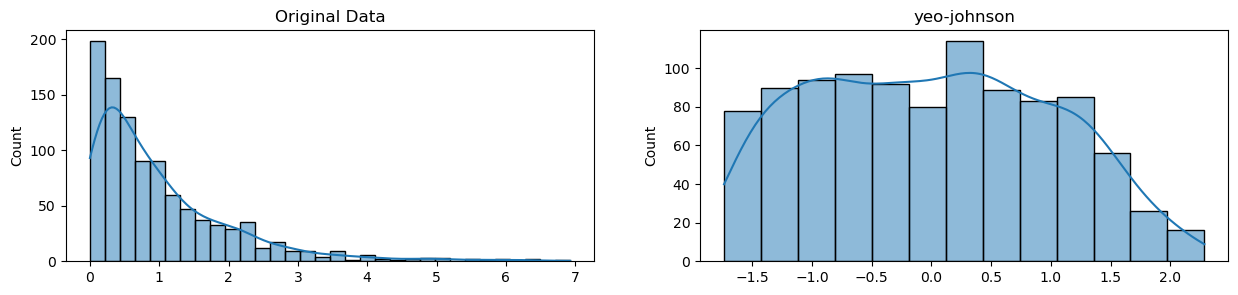

In [176]:
from sklearn.preprocessing import PowerTransformer

data = np.random.exponential(size=1000).reshape(-1,1)

pt = PowerTransformer(method="yeo-johnson")
data_transformed = pt.fit_transform(data)

# plot both together to compare
fig, ax=plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(data_transformed, ax=ax[1], kde=True, legend=False)
ax[1].set_title("yeo-johnson")
plt.show()

---

✅ **Summary:**

* Use **scaling** when the issue is that your features are measured on different ranges or units.
* Use **normalization** when the issue is that your features are **skewed** and your model assumes data should follow a **normal distribution**.

---

# Feature Selection 🎯

When we engineer many features (lags, rolling stats, weather, calendar effects), not all of them improve the model. Some may add **noise** or **redundancy**.
Feature selection helps us keep the most **informative predictors**, leading to:

* ⚡ Faster training
* 🎯 Better generalization (less overfitting)
* 📊 Easier interpretation

---

### ⚡ Example

* In a **winter demand forecast**, temperature and lagged demand may dominate.
* In a **summer PV production forecast**, solar irradiance and hour of day are critical.
* Features like `weekday` may have little effect during holiday weeks.

---

✅ **Summary:**
Feature selection makes your models **simpler and more robust** by focusing on the variables that matter most.



## 🔗 Feature Selection with Mutual Information

One way to measure how useful a feature is for predicting the target is **Mutual Information (MI)**.

---

### 🔎 What is Mutual Information?

* A concept from **information theory**.
* Measures how much **knowing one variable reduces uncertainty** about another.
* Unlike correlation (which is linear), MI can capture **nonlinear relationships**.

Formally:

$$
MI(X, Y) = \sum p(x,y) \log \frac{p(x,y)}{p(x)p(y)}
$$

* **High MI** → feature shares a lot of information with the target.
* **Low MI** → feature does not contribute much predictive power.

---


In [178]:
demand.drop("daytype", axis=1, inplace= True)
demand

,demand,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos,is_weekend,lag1,lag24,lag168,roll_mean_24h,roll_max_24h,T
timestamp,,,,,,,,,,,,,,
2022-01-01 00:00:00,899.4,0,5,0.000000,1.000000,-0.974928,-0.222521,1,NaN,NaN,NaN,NaN,NaN,-1.0
2022-01-01 01:00:00,892.1,1,5,0.258819,0.965926,-0.974928,-0.222521,1,899.4,NaN,NaN,NaN,NaN,-0.6
2022-01-01 02:00:00,874.3,2,5,0.500000,0.866025,-0.974928,-0.222521,1,892.1,NaN,NaN,NaN,NaN,0.0
2022-01-01 03:00:00,860.1,3,5,0.707107,0.707107,-0.974928,-0.222521,1,874.3,NaN,NaN,NaN,NaN,-0.1
2022-01-01 04:00:00,842.7,4,5,0.866025,0.500000,-0.974928,-0.222521,1,860.1,NaN,NaN,NaN,NaN,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,989.4,19,5,-0.965926,0.258819,-0.974928,-0.222521,1,1042.8,1049.9,1009.5,929.462500,1091.7,5.4
2022-12-31 20:00:00,932.5,20,5,-0.866025,0.500000,-0.974928,-0.222521,1,989.4,1019.4,982.7,925.841667,1091.7,5.7
2022-12-31 21:00:00,889.5,21,5,-0.707107,0.707107,-0.974928,-0.222521,1,932.5,981.0,965.4,922.029167,1091.7,5.8


In [179]:
demand = demand.fillna(0)

from sklearn.feature_selection import mutual_info_regression

discrete_features = demand.dtypes == int

mi_scores = mutual_info_regression(demand, demand['demand'], discrete_features=discrete_features)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=demand.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores


demand           7.594802
lag1             1.497243
lag168           0.941154
lag24            0.926515
roll_max_24h     0.704157
roll_mean_24h    0.482601
T                0.305492
hour             0.298685
hour_cos         0.164632
hour_sin         0.108564
weekday_sin      0.063344
weekday          0.063260
is_weekend       0.052476
weekday_cos      0.025340
Name: MI Scores, dtype: float64

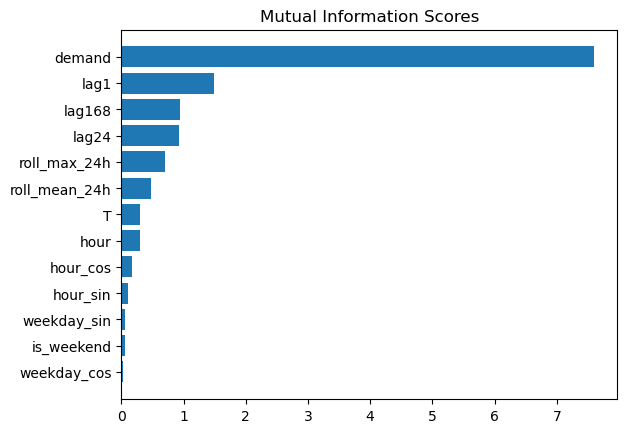

In [144]:
mi_scores = mi_scores.sort_values(ascending=True)
width = np.arange(len(mi_scores))
ticks = list(mi_scores.index)
plt.barh(width, mi_scores)
plt.yticks(width, ticks)
plt.title("Mutual Information Scores");

## 🔎 Pairplot for Feature Exploration

When we create many new features (lags, cyclical transforms, weather variables), it’s important to **explore their relationships**.
A great tool for this is `sns.pairplot()` from **Seaborn**.

---

### 📊 How to Read It

* **Each cell** is a scatterplot of two features.
* **Diagonal cells** show the distribution of a single feature.
* You can quickly spot:

  * 📈 **Correlations** (e.g., demand vs temperature).
  * 🔄 **Cyclical patterns** (sin/cos encodings forming circles).
  * 📊 **Nonlinear relationships** (e.g., demand vs hour).
* The plot helps check if engineered features behave as expected.

---

✅ **Summary:**

* `sns.pairplot` gives a quick **all-vs-all** feature comparison.
* Useful after feature engineering to **validate transformations**.
* Look for patterns that confirm (or contradict) your domain knowledge.


In [180]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8761 entries, 2022-01-01 00:00:00 to 2022-12-31 23:00:00
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   demand         8761 non-null   float64
 1   hour           8761 non-null   int32  
 2   weekday        8761 non-null   int32  
 3   hour_sin       8761 non-null   float64
 4   hour_cos       8761 non-null   float64
 5   weekday_sin    8761 non-null   float64
 6   weekday_cos    8761 non-null   float64
 7   is_weekend     8761 non-null   int64  
 8   lag1           8761 non-null   float64
 9   lag24          8761 non-null   float64
 10  lag168         8761 non-null   float64
 11  roll_mean_24h  8761 non-null   float64
 12  roll_max_24h   8761 non-null   float64
 13  T              8761 non-null   float64
dtypes: float64(11), int32(2), int64(1)
memory usage: 958.2 KB


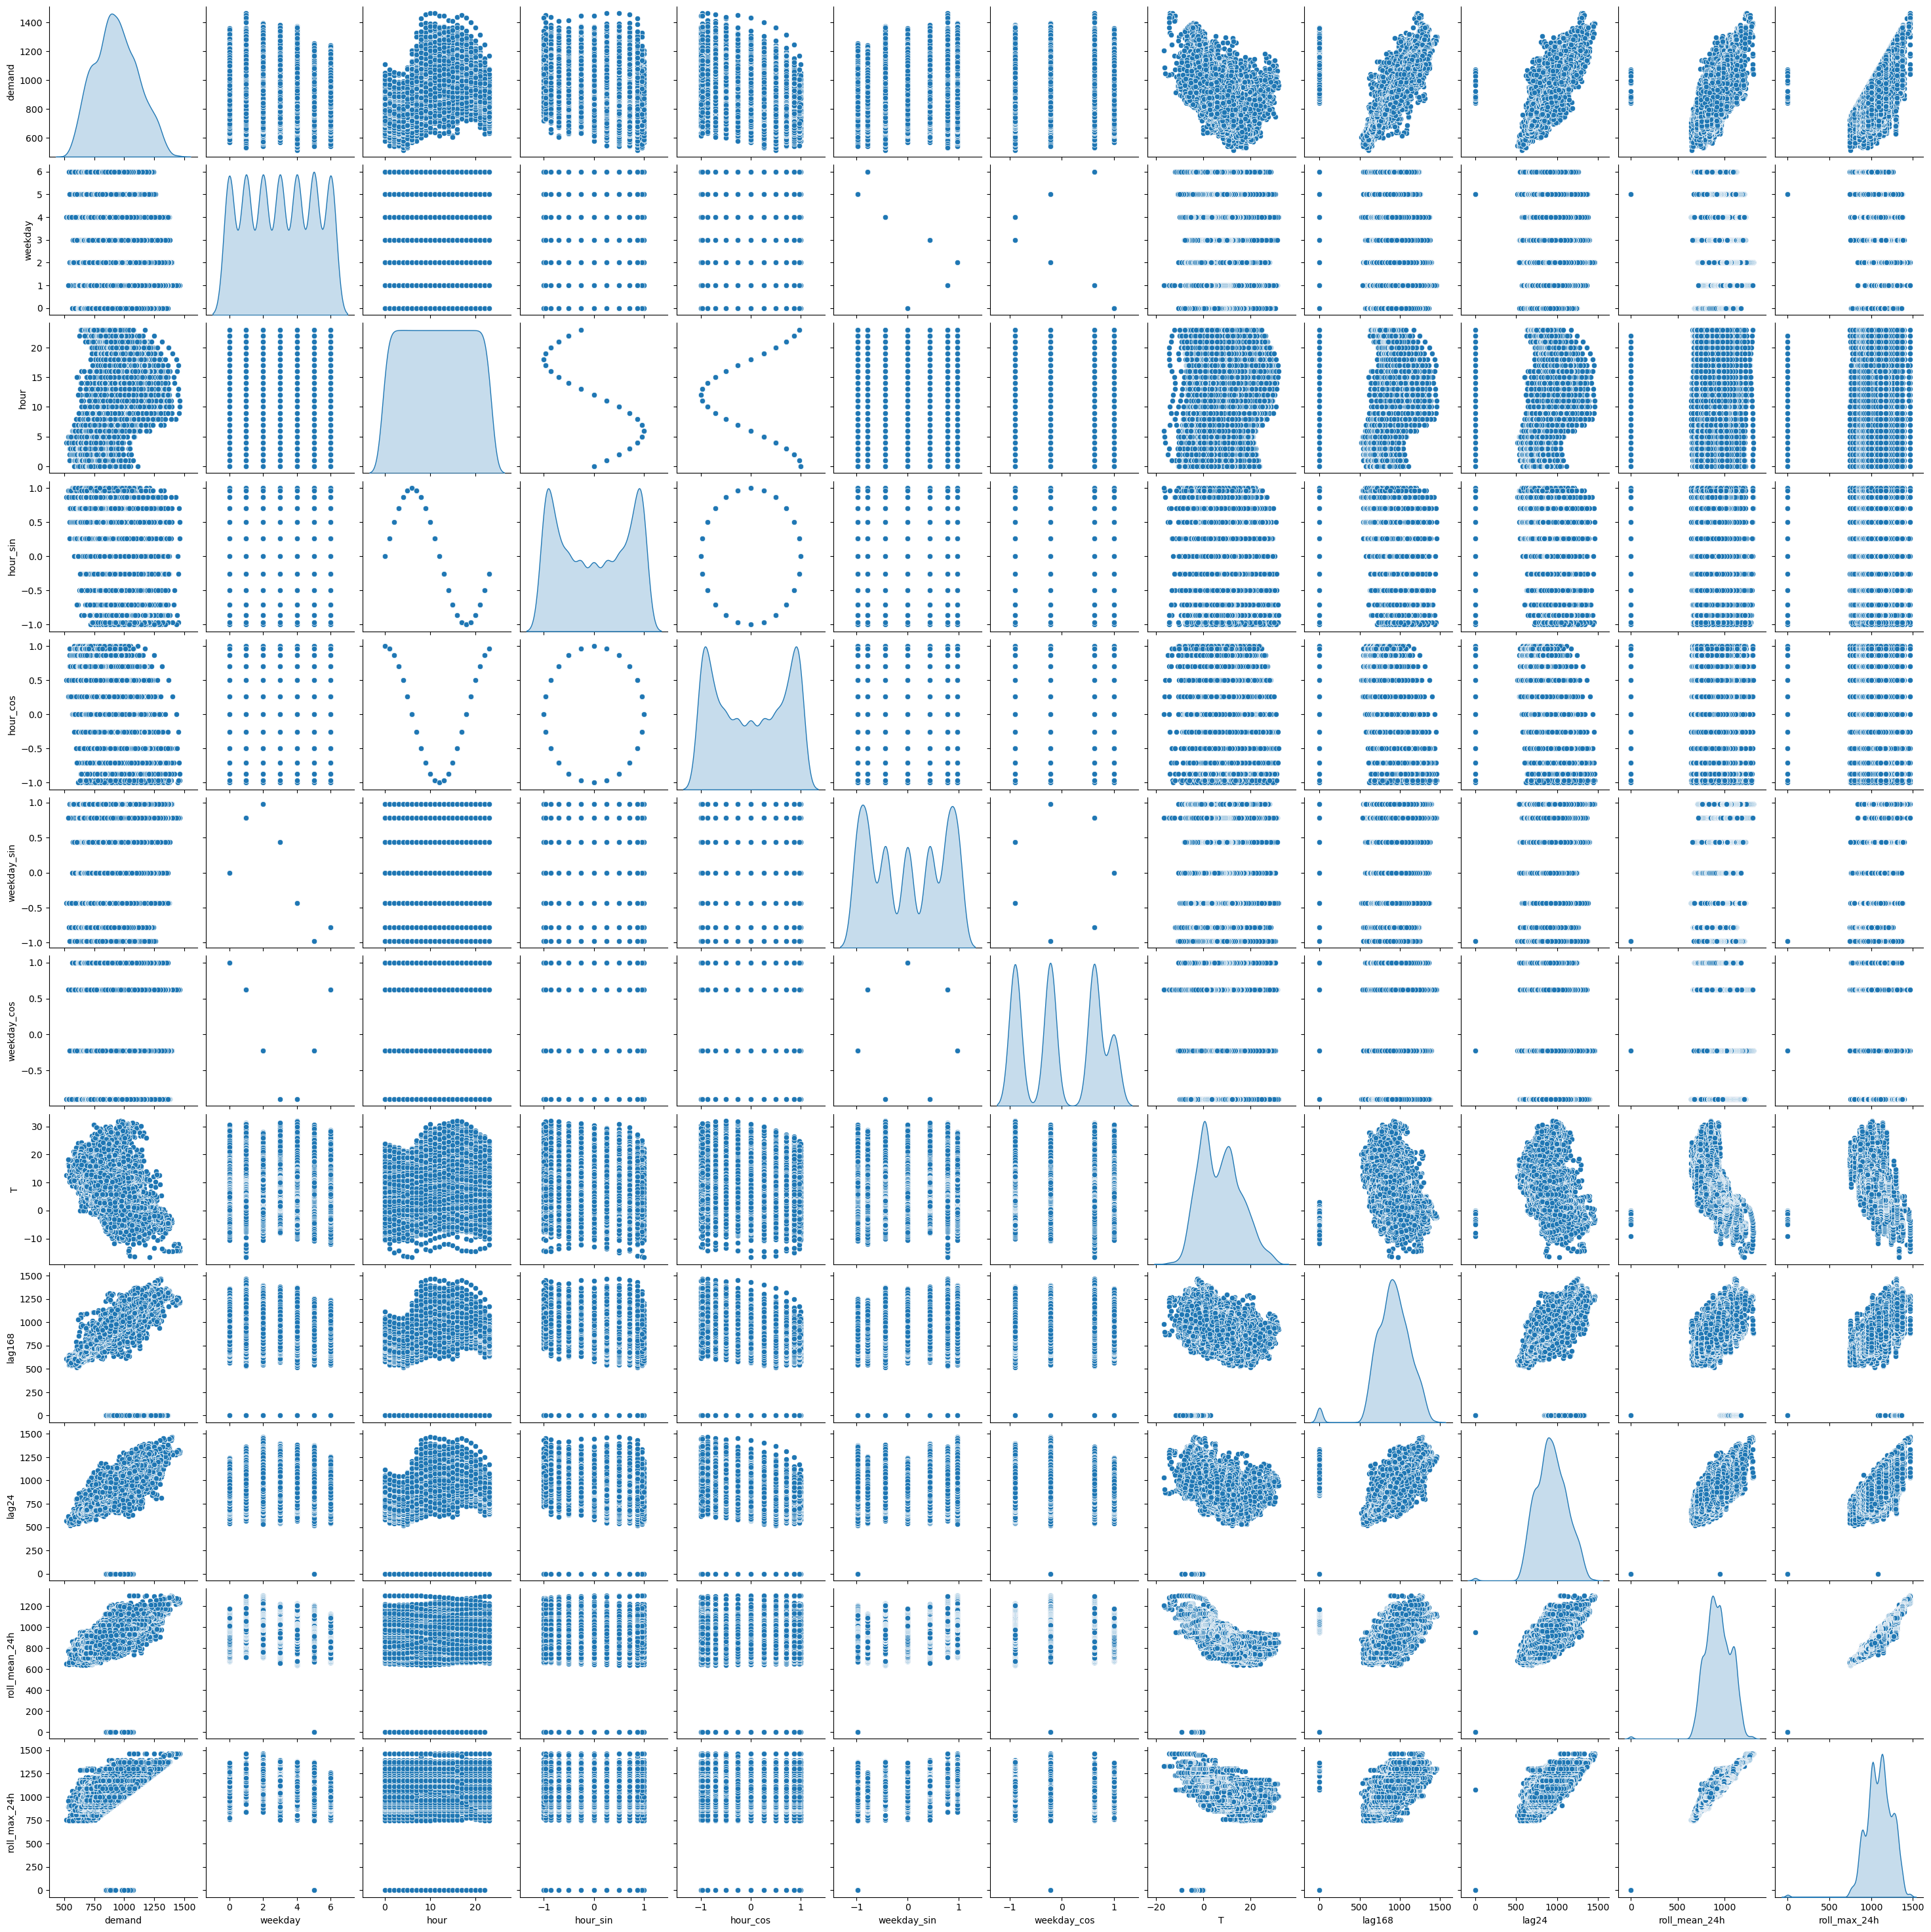

In [181]:
sns.pairplot(demand[['demand','weekday','hour','hour_sin','hour_cos','weekday_sin',
                         'weekday_cos', 'T','lag168', 'lag24', 'roll_mean_24h', 'roll_max_24h']], diag_kind='kde');

## 🔗 Correlation Matrix

When we engineer many new features (lags, rolling stats, weather, cyclical encodings), it’s useful to check **how strongly they correlate** with each other and with the target.
A **correlation matrix** summarizes pairwise correlations between variables.

---

### 🔎 Why Correlation Matters?

* 📊 **Detect redundancy** → highly correlated features add little new information.
* ⚡ **Spot relationships** → e.g., temperature vs demand (negative in winter, positive in summer).
* 🎯 **Feature selection** → keep the most informative, drop those with near-duplicate info.

---

### 📊 How to Read It

* Values range from **-1 to 1**:

  * `1.0` = perfect positive correlation.
  * `-1.0` = perfect negative correlation.
  * `0` = no linear relationship.
* **Diagonal** = always 1.0 (self-correlation).
* Look for:

  * High correlation between **sin/cos encodings** (expected, they’re related).
  * Demand vs temperature correlation → depends on season.
  * Lagged demand often has very high correlation with current demand.

---


✅ **Summary**

* Correlation matrices help **spot redundancy** and **understand linear relationships**.
* Use them as a **first filter** in feature selection.
* But remember: correlation only measures **linear dependence** — nonlinear relations may require **mutual information** or other methods.



In [182]:
demand.corr()

,demand,hour,weekday,hour_sin,hour_cos,weekday_sin,weekday_cos,is_weekend,lag1,lag24,lag168,roll_mean_24h,roll_max_24h,T
demand,1.000000,0.374993,-0.229259,-0.322306,-0.477886,0.232213,-0.039491,-0.270844,0.966698,0.846281,0.642737,0.643815,0.644408,-0.470091
hour,0.374993,1.000000,-0.000185,-0.775945,-0.102228,0.000136,-0.000109,-0.000195,0.450602,0.361048,0.300297,0.001337,0.008291,0.116044
weekday,-0.229259,-0.000185,1.000000,0.000209,0.000121,-0.735061,-0.353671,0.791166,-0.226750,-0.009474,-0.183749,-0.168493,-0.227112,-0.010194
hour_sin,-0.322306,-0.775945,0.000209,1.000000,0.000099,-0.000154,0.000124,0.000220,-0.434316,-0.309968,-0.257159,-0.000414,-0.004888,-0.142308
hour_cos,-0.477886,-0.102228,0.000121,0.000099,1.000000,-0.000089,0.000071,0.000127,-0.378383,-0.460058,-0.383139,0.001054,-0.048248,-0.122481
weekday_sin,0.232213,0.000136,-0.735061,-0.000154,-0.000089,1.000000,0.001074,-0.786908,0.231292,0.128829,0.185612,0.257975,0.286625,0.023209
weekday_cos,-0.039491,-0.000109,-0.353671,0.000124,0.000071,0.001074,1.000000,0.177451,-0.041319,-0.194806,-0.032861,-0.160607,-0.134759,-0.030117
is_weekend,-0.270844,-0.000195,0.791166,0.000220,0.000127,-0.786908,0.177451,1.000000,-0.269462,-0.109206,-0.217410,-0.270446,-0.304760,-0.029386
lag1,0.966698,0.450602,-0.226750,-0.434316,-0.378383,0.231292,-0.041319,-0.269462,1.000000,0.825707,0.624029,0.653332,0.651323,-0.464310
lag24,0.846281,0.361048,-0.009474,-0.309968,-0.460058,0.128829,-0.194806,-0.109206,0.825707,1.000000,0.638932,0.707140,0.693721,-0.418148


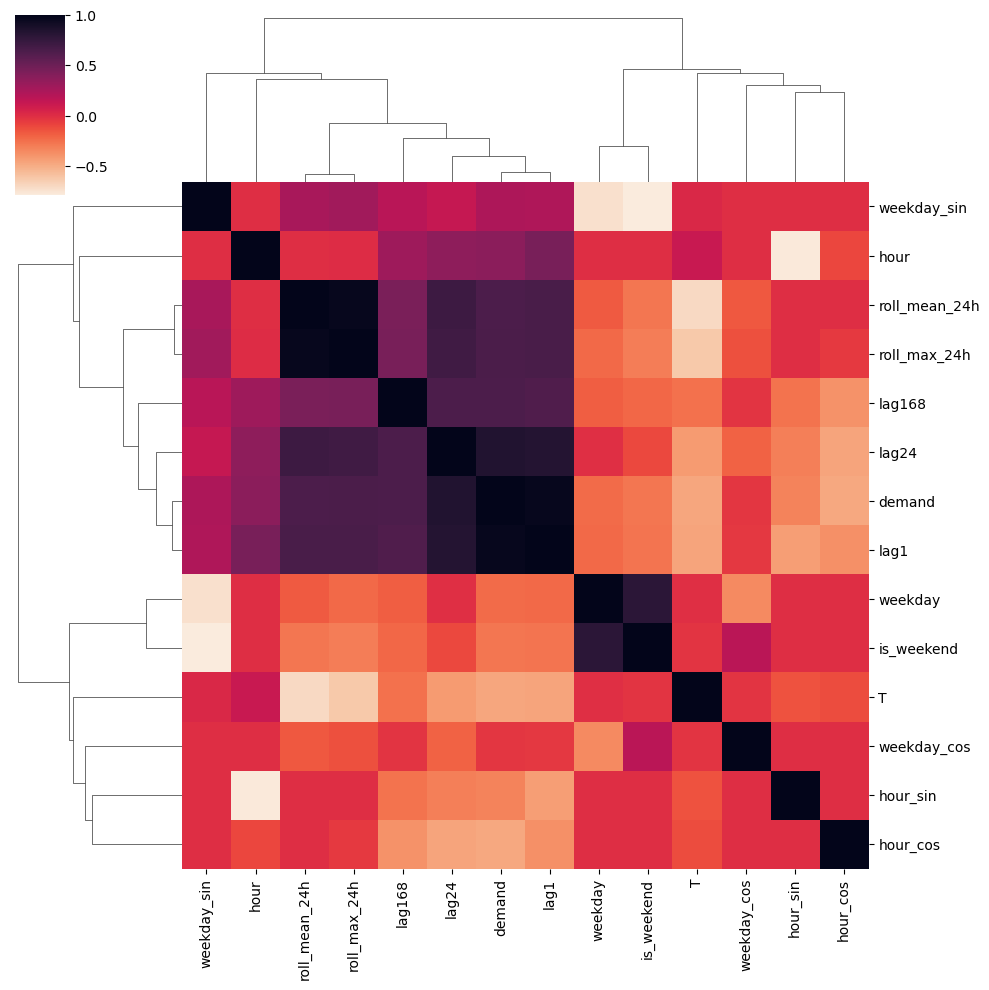

In [183]:
sns.clustermap(demand.corr(), cmap="rocket_r");

## 🌳 Tree-Based Models for Feature Importance

Tree-based models, such as **Random Forests** or **Gradient Boosted Trees**, naturally provide a ranking of feature importance:

* Each split in the tree reduces prediction error.
* The total reduction in error from splits on a feature = **feature importance score**.

---


✅ **Summary**

* Some features add little or no value → better to drop them.
* Tree-based models can **automatically rank features by importance**.
* Use this ranking to guide **feature selection**, alongside domain knowledge.



In [184]:
from sklearn.ensemble import RandomForestRegressor

X = demand.dropna()[['weekday','hour','hour_sin','hour_cos','weekday_sin',
                         'weekday_cos', 'T','lag168', 'lag24', 'roll_mean_24h', 'roll_max_24h']]
y = demand.dropna()['demand']

rf = RandomForestRegressor(n_estimators=50, random_state=0)
rf.fit(X,y)

feat_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feat_importance)

lag24            0.519154
lag168           0.318983
roll_max_24h     0.053742
roll_mean_24h    0.041087
T                0.017002
hour_cos         0.012619
weekday_sin      0.012189
weekday          0.007656
hour             0.007311
hour_sin         0.005335
weekday_cos      0.004922
dtype: float64


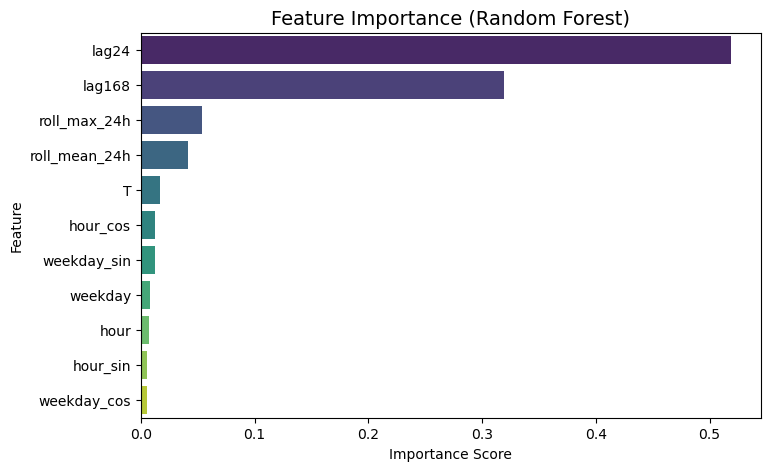

In [185]:
plt.figure(figsize=(8,5))
sns.barplot(x=feat_importance.values, y=feat_importance.index, palette="viridis")
plt.title("Feature Importance (Random Forest)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


---

# ✅ Wrap-Up

* Calendar → capture cycles
* Lags → memory
* Rolling → trends
* Weather → external drivers
* Cyclical encoding → time patterns
* Scaling → helps ML
* Selection → removes noise

